### Basic Usage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hiveplotlib import Axis, HivePlot, Node, hive_plot_n_axes
from hiveplotlib.viz import axes_viz, edge_viz, hive_plot_viz, node_viz

`hiveplotlib` allows users to take network data, choose a set of axes and sorting procedures, and visualize the resulting connectivity in a way that is both intuitive and reproducible.

In this notebook, we build up the concepts of Hive Plots starting from the low-level API using the `hiveplotlib.Node`, `hiveplotlib.Axis`, and `hiveplotlib.HivePlot` classes up to the high-level API call with `hiveplotlib.hive_plot_n_axes()`.

If you trying to quickly generate hive plots, we recommend skipping to the [Quick Start Hive Plots](https://geomdata.gitlab.io/hiveplotlib/quick_hive_plots.html) notebook.

This package is intended to be used solely for visualization, not featurization. Consequently, the package is structured only to take records of already-featurized data and arrays of edges and offer a framework for rapidly generating Hive Plots.

If you want to generate graph features beforehand in Python, <a href="https://networkx.github.io/">`networkx`</a> is a good tool for this. We have several examples going from `networkx` objects to Hive Plots in the [Networkx Examples](https://geomdata.gitlab.io/hiveplotlib/networkx_examples.html) notebook. We also include an example with <a href="https://geomdata.gitlab.io/hiveplotlib/public/karate_club.html"> Zachary's Karate Club</a>. Both of these notebooks demonstrate how to convert from the `networkx` data structure to our necessary data structures using the `hiveplotlib.converters.networkx_to_nodes_edges()` method.

#### Data Inputs

In order to use this package, we need to wrangle two sources of data, **nodes** and **edges**.


##### Nodes

Setting up a node in our framework simply requires a dictionary of data and a unique_id to go along with it. This will play particularly nicely with any `json` output from a database query (for example, queries from a Mongo database through `pymongo`). `pandas` dataframes can also easily be converted into this format with `df.to_dict(orient="records")`.

##### Edges

Edges are simply stored as an `(n, 2) numpy.ndarray`, where the edges (if directed) move _from_ the first column _to_ the second column.

#### Example Data

We will now generate a synthetic example that will persist for the rest of the demo.

In [2]:
# generate synthetic node data from a pandas dataframe
num_nodes = 50
rng = np.random.default_rng(0)
data = pd.DataFrame(
    np.c_[
        rng.uniform(low=0, high=10, size=num_nodes),
        rng.uniform(low=10, high=20, size=num_nodes),
        rng.uniform(low=20, high=30, size=num_nodes),
    ],
    columns=["low", "med", "high"],
)
data.head()

low        med       high
0  6.369617  17.870983  24.799879
1  2.697867  12.393694  22.323729
2  0.409735  18.764842  28.018806
3  0.165276  10.585680  29.235302
4  8.132702  13.361171  22.661303

In [3]:
# convert into dictionaries for later use
node_data = data.to_dict(orient="records")

# use the dataframe's index as unique id
node_ids = data.index.to_numpy()

print(f"Data for Node {node_ids[0]}:\n{node_data[0]}")

Data for Node 0:
{'low': 6.369616873214543, 'med': 17.870983074886833, 'high': 24.799879238078322}


In [4]:
# generate random edges
num_edges = 200

edges = rng.choice(node_ids, size=num_edges * 2).reshape(-1, 2)
edges[:5, :]

array([[ 5,  0],
       [ 5, 18],
       [ 5,  3],
       [12, 32],
       [26, 13]])

With our node and edge data set, we can now start building `Node`, `Axis`, and finally `HivePlot` instances.

#### `Node` Instances

`Node` instances are simply dictionaries with unique identifiers.

Let's quick convert our node data into `Node` instances.

In [5]:
nodes = [
    Node(unique_id=node_id, data=node_data[i]) for i, node_id in enumerate(node_ids)
]

#### `Axis` Instances

Next, let's generate some axes on which we will later place nodes.

`Axis` instances need 4 things to instantiate:

- a unique ID, which we will use to reference the axis later on.
- a starting position, representing distance from the origin.
- a stopping position, also representing distance from the origin.
- an angle, representing the angle off of the positive x axis moving counterclockwise.

We also include `long_name`s here for visualization purposes later.

In our current example, let's start with equally-spaced axes of the same size, all with some distance off the origin (this will make visualizing the edges easier later).

In [6]:
axis_low = Axis(axis_id="l", start=1, end=5, angle=0, long_name="Low")
axis_med = Axis(axis_id="m", start=1, end=5, angle=120, long_name="Medium")
axis_high = Axis(axis_id="h", start=1, end=5, angle=240, long_name="High")

axes = [axis_low, axis_med, axis_high]

#### The `HivePlot` Instance

We're now ready to put these pieces together into a `HivePlot` instance.

In [7]:
hp = HivePlot()
hp.add_nodes(nodes)
hp.add_axes(axes)

At this point, we have the means to create a visualization, albeit one that is rather limited.

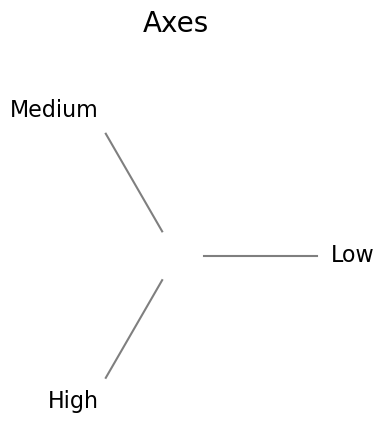

In [8]:
fig, ax = axes_viz(hp, figsize=(4, 4))
ax.set_title("Axes", y=1.2, fontsize=20)
plt.show()

Note that we could try to plot nodes as well as edges, but nothing will appear because we have not yet drawn any edges nor placed any nodes on any axes.

/tmp/ipykernel_349313/3496363112.py:2: UserWarning: At least one of your axes has no nodes placed on it yet. Nodes can be placed on axes by running `HivePlot.place_nodes_on_axis()`
  node_viz(hp, fig=fig, ax=ax)
/tmp/ipykernel_349313/3496363112.py:3: UserWarning: Your `HivePlot` instance does not have any specified edges yet. Edges can be created for plotting by running `HivePlot.connect_axes()`
  edge_viz(hp, fig=fig, ax=ax)


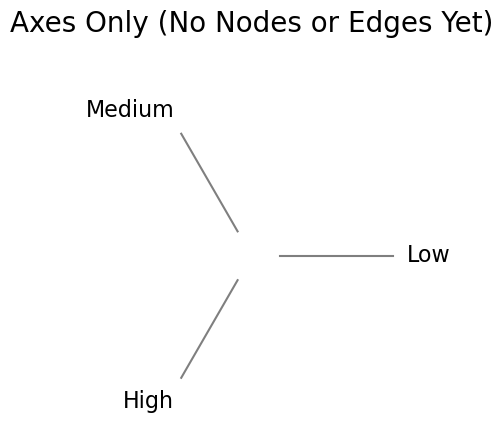

In [9]:
fig, ax = axes_viz(hp, figsize=(4, 4))
node_viz(hp, fig=fig, ax=ax)
edge_viz(hp, fig=fig, ax=ax)
ax.set_title("Axes Only (No Nodes or Edges Yet)", y=1.2, fontsize=20)
plt.show()

#### Assigning and Placing Nodes on Axes

Next, let's assign and place nodes to axes. This requires us to:

1) Partition the node IDs among the axes.

2) Choose a sorting procedure for each axis.

This is all nicely handled by the `place_nodes_on_axis()` method.

In [10]:
# split the nodes roughly into thirds
#  taking advantage of the naming being integers from 0 to `num_nodes`
hp.place_nodes_on_axis(
    axis_id="l",
    unique_ids=np.arange(num_nodes)[: num_nodes // 3],
    sorting_feature_to_use="low",
)
hp.place_nodes_on_axis(
    axis_id="m",
    unique_ids=np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
    sorting_feature_to_use="med",
)
hp.place_nodes_on_axis(
    axis_id="h",
    unique_ids=np.arange(num_nodes)[2 * num_nodes // 3 :],
    sorting_feature_to_use="high",
)

Now that the nodes have been placed in Cartesian space, we will now get nodes in our visualization (and only a warning about a lack of edges to draw).

/tmp/ipykernel_349313/2743636190.py:4: UserWarning: Your `HivePlot` instance does not have any specified edges yet. Edges can be created for plotting by running `HivePlot.connect_axes()`
  edge_viz(hp, fig=fig, ax=ax)


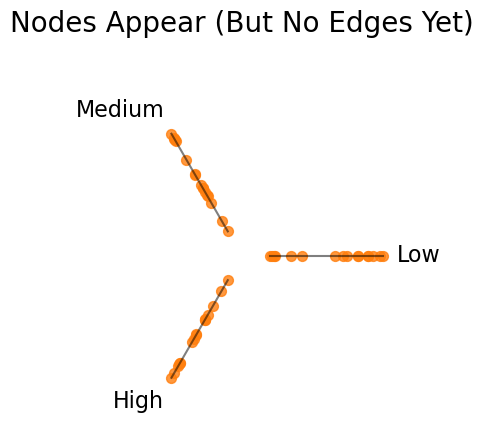

In [11]:
fig, ax = axes_viz(hp, figsize=(4, 4))
# bigger, brighter nodes to emphasize their visual arrival
node_viz(hp, fig=fig, ax=ax, color="C1", s=50, alpha=0.8)
edge_viz(hp, fig=fig, ax=ax)
ax.set_title("Nodes Appear (But No Edges Yet)", y=1.2, fontsize=20)
plt.show()

Finally, we need to declare which edges to draw, as well as set any plotting kwargs for each set of edges we draw.

In [12]:
# variation in edges to display flexibility of code

# construct edges in both directions
hp.connect_axes(edges=edges, axis_id_1="l", axis_id_2="m", color="C1")

# both directions, different style
hp.connect_axes(edges=edges, axis_id_1="l", axis_id_2="h", color="C2", ls="dotted")

# different styles in each direction
hp.connect_axes(edges=edges, axis_id_1="h", axis_id_2="m", a2_to_a1=False, color="C0")
hp.connect_axes(
    edges=edges, axis_id_1="h", axis_id_2="m", a1_to_a2=False, color="C0", ls="--"
)

0

With this completed, we can now build a full visualization.

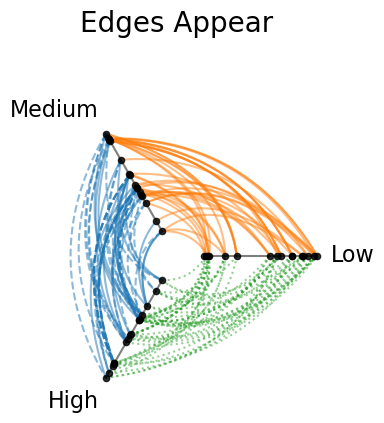

In [13]:
fig, ax = axes_viz(hp, figsize=(4, 4))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
# put the edges behind nodes by changing the zorder
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title("Edges Appear", y=1.2, fontsize=20)
plt.show()

#### Changing Our Axis Sorting

If we want to change our sorting procedure for an axis, this will nullify any edges going to or from that axis.

In [14]:
# no need to re-specify which nodes go to this axis, just change the sorting procedure
hp.place_nodes_on_axis(axis_id="l", sorting_feature_to_use="med")

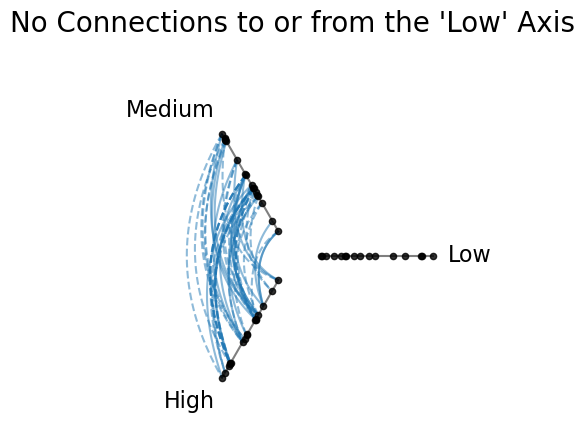

In [15]:
fig, ax = axes_viz(hp, figsize=(4, 4))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
# put the edges behind nodes by changing the zorder
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title("No Connections to or from the 'Low' Axis", y=1.2, fontsize=20)
plt.show()

Lost edges can be added back easily using the `construct_curves()` method, which adds in all previously-defined curves. Note, this is still a single call, even if we reset multiple axes.

In [16]:
hp.construct_curves()

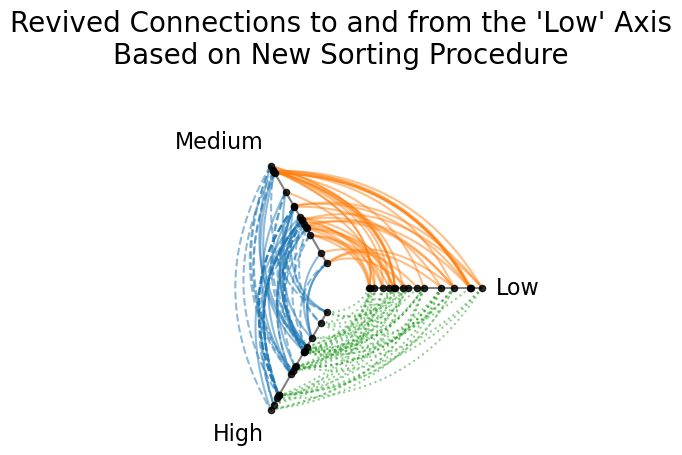

In [17]:
fig, ax = axes_viz(hp, figsize=(4, 4))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
# put the edges behind nodes by changing the zorder
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title(
    "Revived Connections to and from the 'Low' Axis\nBased on New Sorting Procedure",
    y=1.2,
    fontsize=20,
)
plt.show()

Note that one could also change the node assignments as well.

#### `vmin` and `vmax` on the Axes

You might be wondering how the axes are fully spanned by edges even after we changed the sorting procedure for an axis. This is due to the default placement of nodes on an axis is to have the min and max values on the axis line up exactly with the respective min and max values of the sorting feature. Just as this can be changed with color maps in `matplotlib`, we can specify a `vmin` and `vmax` level. This is particularly relevant when:

- There is a strong outlier value for one node or a few nodes

- If we use comparable sorting procedures on multiple axes, we may be interested in relative placement on several axes, not just the ordering within one axis.

This is a quick fix through our `place_nodes_on_axis()` call.

In [18]:
# re-place all of the nodes, bringing low back to low
#  and set vmin and vmax values
hp.place_nodes_on_axis(axis_id="l", sorting_feature_to_use="low", vmin=0, vmax=30)
hp.place_nodes_on_axis(axis_id="m", vmin=0, vmax=30)
hp.place_nodes_on_axis(axis_id="h", vmin=0, vmax=30)

# rebuild all the curves
hp.construct_curves()

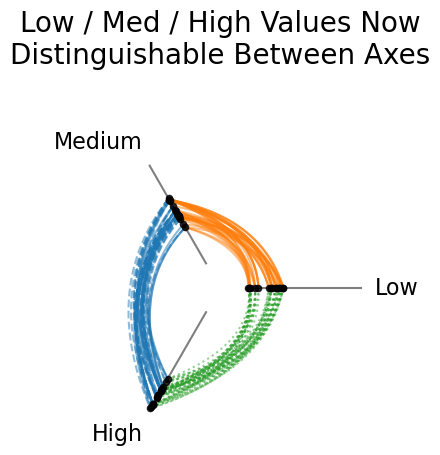

In [19]:
fig, ax = axes_viz(hp, figsize=(4, 4))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
# put the edges behind nodes by changing the zorder
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title(
    "Low / Med / High Values Now\nDistinguishable Between Axes", y=1.2, fontsize=20
)
plt.show()

#### Repeat Axes for Within-Group Behavior

There's one big lie with the current visualization, and that's the assumption that there are _only_ edges between these groups and no edges _within_ each group.

To fix this, we will need a _repeat axis_ for each group, for a total of 6 axes. We'll start from scratch so we can better position the 6 axes relative to each other.

In [20]:
# six axes this time
axis_low = Axis(axis_id="l", start=1, end=5, angle=-50, long_name="Low")
axis_low_repeat = Axis(axis_id="l_repeat", start=1, end=5, angle=-10, long_name="Low")

axis_med = Axis(axis_id="m", start=1, end=5, angle=70, long_name="Medium")
axis_med_repeat = Axis(
    axis_id="m_repeat", start=1, end=5, angle=110, long_name="Medium"
)

axis_high = Axis(axis_id="h", start=1, end=5, angle=190, long_name="High")
axis_high_repeat = Axis(axis_id="h_repeat", start=1, end=5, angle=230, long_name="High")

axes = [
    axis_low,
    axis_low_repeat,
    axis_med,
    axis_med_repeat,
    axis_high,
    axis_high_repeat,
]

hp = HivePlot()
hp.add_nodes(nodes)
hp.add_axes(axes)

# place the *same* nodes on repeat axes (not specifying vmin and vmax here)
hp.place_nodes_on_axis(
    axis_id="l",
    unique_ids=np.arange(num_nodes)[: num_nodes // 3],
    sorting_feature_to_use="low",
)
hp.place_nodes_on_axis(
    axis_id="l_repeat",
    unique_ids=np.arange(num_nodes)[: num_nodes // 3],
    sorting_feature_to_use="low",
)

hp.place_nodes_on_axis(
    axis_id="m",
    unique_ids=np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
    sorting_feature_to_use="med",
)
hp.place_nodes_on_axis(
    axis_id="m_repeat",
    unique_ids=np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
    sorting_feature_to_use="med",
)

hp.place_nodes_on_axis(
    axis_id="h",
    unique_ids=np.arange(num_nodes)[2 * num_nodes // 3 :],
    sorting_feature_to_use="high",
)
hp.place_nodes_on_axis(
    axis_id="h_repeat",
    unique_ids=np.arange(num_nodes)[2 * num_nodes // 3 :],
    sorting_feature_to_use="high",
)

# same edges as before, but we need to be careful to not overlap other axes
hp.connect_axes(edges=edges, axis_id_1="l_repeat", axis_id_2="m", color="C1")

# both directions, different style
hp.connect_axes(
    edges=edges, axis_id_1="l", axis_id_2="h_repeat", color="C2", ls="dotted"
)

# different styles in each direction
hp.connect_axes(
    edges=edges, axis_id_1="h", axis_id_2="m_repeat", a2_to_a1=False, color="C0"
)
hp.connect_axes(
    edges=edges,
    axis_id_1="h",
    axis_id_2="m_repeat",
    a1_to_a2=False,
    color="C0",
    ls="--",
)

# plus the repeat edges
#  (no need to do bidirectional here, just leads to the edges but flipped)
hp.connect_axes(
    edges=edges, axis_id_1="l", axis_id_2="l_repeat", a2_to_a1=False, color="C4"
)
hp.connect_axes(
    edges=edges, axis_id_1="m", axis_id_2="m_repeat", a2_to_a1=False, color="C5"
)
hp.connect_axes(
    edges=edges, axis_id_1="h", axis_id_2="h_repeat", a2_to_a1=False, color="C6"
)

0

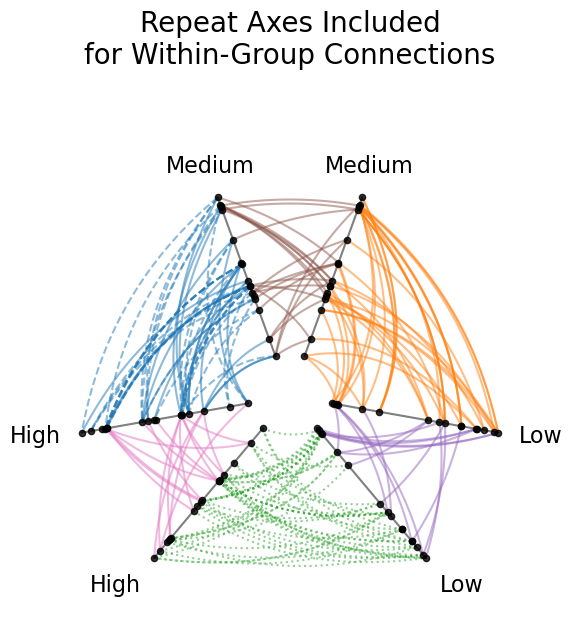

In [21]:
fig, ax = axes_viz(hp, figsize=(6, 6))
node_viz(hp, fig=fig, ax=ax, color="black", s=20, alpha=0.8)
# put the edges behind nodes by changing the zorder
edge_viz(hp, fig=fig, ax=ax, zorder=-1)
ax.set_title("Repeat Axes Included\nfor Within-Group Connections", y=1.2, fontsize=20)
plt.show()

#### Exploration with Less Overhead

Trying to explore quickly before you beautify your `matplotlib` figure? We also have a means to generate a `HivePlot` instance and plot in only two function calls, albeit with less flexibility.

`hiveplotlib.hive_plot_n_axes()` allows the generation of a `HivePlot` instance with as little as a list of `Node` instances, an array of edges, a list of lists of node IDs, and a list of sorting variables for each axis.

`hiveplotlib.viz.hive_plot_viz()` will plot a `HivePlot` instance's axes, nodes, edges all at once. The default functionality sets edge kwargs to plot counterclockwise edges in solid black and clockwise edges in dashed black.

Let's consider the example we've been following throughout.

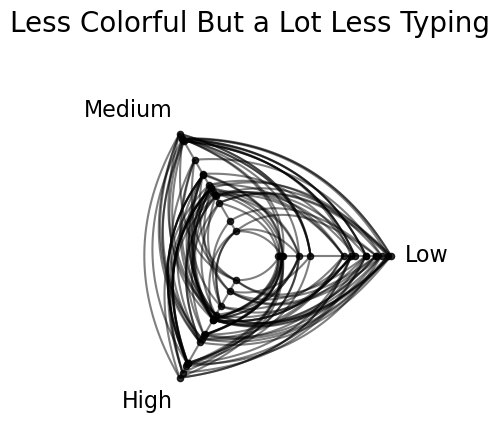

In [22]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=[
        np.arange(num_nodes)[: num_nodes // 3],
        np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
        np.arange(num_nodes)[2 * num_nodes // 3 :],
    ],
    sorting_variables=["low", "med", "high"],
    axes_names=["Low", "Medium", "High"],
)

fig, ax = hive_plot_viz(hp, figsize=(4, 4))
ax.set_title("Less Colorful But a Lot Less Typing", y=1.2, fontsize=20)
plt.show()

We can modify the edge kwargs with the `HivePlot.add_edge_kwargs()` method.

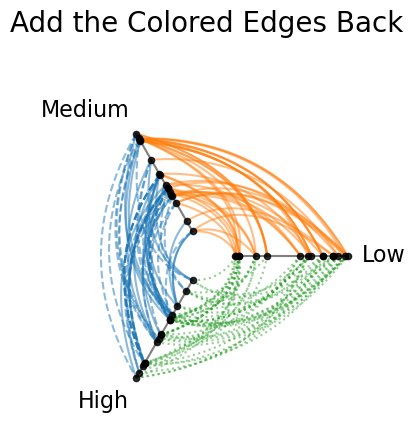

In [23]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=[
        np.arange(num_nodes)[: num_nodes // 3],
        np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
        np.arange(num_nodes)[2 * num_nodes // 3 :],
    ],
    sorting_variables=["low", "med", "high"],
    axes_names=["Low", "Medium", "High"],
)

# use the same kwargs as before
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="Medium", color="C1", ls="-")
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="High", color="C2", ls="dotted")
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium", a2_to_a1=False, color="C0", ls="-"
)
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium", a1_to_a2=False, color="C0", ls="--"
)

fig, ax = hive_plot_viz(hp, figsize=(4, 4))
ax.set_title("Add the Colored Edges Back", y=1.2, fontsize=20)
plt.show()

We can control the `vmin` and `vmax` values on the axes through our `hive_plot_n_axes()` call.

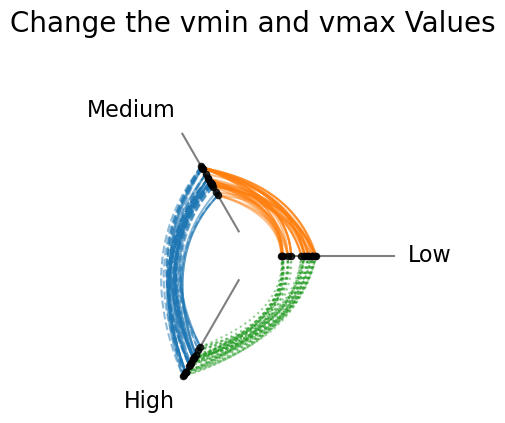

In [24]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=[
        np.arange(num_nodes)[: num_nodes // 3],
        np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
        np.arange(num_nodes)[2 * num_nodes // 3 :],
    ],
    sorting_variables=["low", "med", "high"],
    vmins=[0, 0, 0],
    vmaxes=[30, 30, 30],
    axes_names=["Low", "Medium", "High"],
)

# use the same kwargs as before
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="Medium", color="C1", ls="-")
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="High", color="C2", ls="dotted")
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium", a2_to_a1=False, color="C0", ls="-"
)
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium", a1_to_a2=False, color="C0", ls="--"
)

fig, ax = hive_plot_viz(hp, figsize=(4, 4))
ax.set_title("Change the vmin and vmax Values", y=1.2, fontsize=20)
plt.show()

We can also add repeat axes for any specified axis through a boolean value in `hive_plot_n_axes()`.

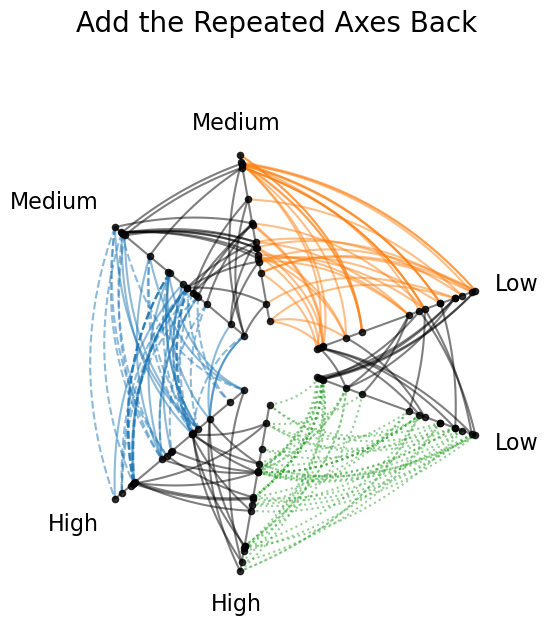

In [25]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=[
        np.arange(num_nodes)[: num_nodes // 3],
        np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
        np.arange(num_nodes)[2 * num_nodes // 3 :],
    ],
    sorting_variables=["low", "med", "high"],
    repeat_axes=[True, True, True],
    axes_names=["Low", "Medium", "High"],
)

# axes constructed by default in counterclockwise order
#  repeat axis with name + "_repeat" always follows 'after' the original axis
hp.add_edge_kwargs(axis_id_1="Low_repeat", axis_id_2="Medium", color="C1", ls="-")
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="High_repeat", color="C2", ls="dotted")
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium_repeat", a2_to_a1=False, color="C0", ls="-"
)
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium_repeat", a1_to_a2=False, color="C0", ls="--"
)

fig, ax = hive_plot_viz(hp, figsize=(6, 6))
ax.set_title("Add the Repeated Axes Back", y=1.2, fontsize=20)
plt.show()

Finally, we can modify the repeat axes' edge kwargs, each of which is automatically named the same name as the original axis with `_repeat` appended on to the name. We can also rotate the figure using the `orient_angle` parameter.

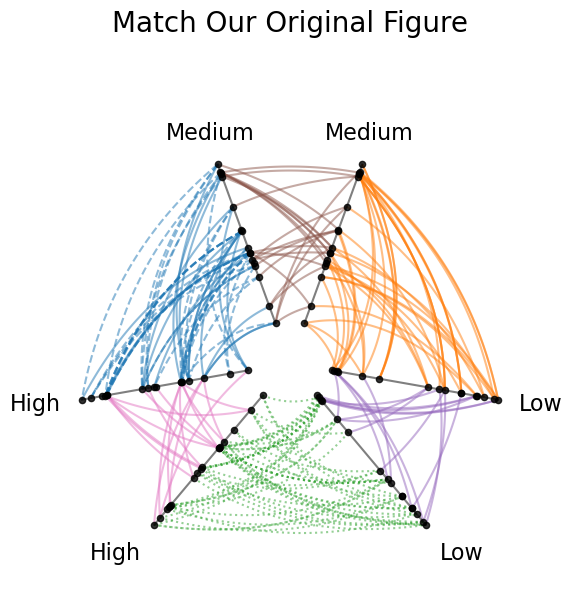

In [26]:
hp = hive_plot_n_axes(
    node_list=nodes,
    edges=edges,
    axes_assignments=[
        np.arange(num_nodes)[: num_nodes // 3],
        np.arange(num_nodes)[num_nodes // 3 : 2 * num_nodes // 3],
        np.arange(num_nodes)[2 * num_nodes // 3 :],
    ],
    sorting_variables=["low", "med", "high"],
    repeat_axes=[True, True, True],
    axes_names=["Low", "Medium", "High"],
    orient_angle=-30,
)

# axes constructed by default in counterclockwise order
#  repeat axis with name + "_repeat" always follows 'after' the original axis
hp.add_edge_kwargs(axis_id_1="Low_repeat", axis_id_2="Medium", color="C1", ls="-")
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="High_repeat", color="C2", ls="dotted")
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium_repeat", a2_to_a1=False, color="C0", ls="-"
)
hp.add_edge_kwargs(
    axis_id_1="High", axis_id_2="Medium_repeat", a1_to_a2=False, color="C0", ls="--"
)

# color the repeat edges
hp.add_edge_kwargs(axis_id_1="Low", axis_id_2="Low_repeat", color="C4")
hp.add_edge_kwargs(axis_id_1="Medium", axis_id_2="Medium_repeat", color="C5")
hp.add_edge_kwargs(axis_id_1="High", axis_id_2="High_repeat", color="C6")


fig, ax = hive_plot_viz(hp, figsize=(6, 6))
ax.set_title("Match Our Original Figure", y=1.2, fontsize=20)
plt.show()